In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from statistics import mean
from matplotlib import rc
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gdoom

#VI LAVER VIZDOOM
environments = []
environments.append("doom_scenario2_96-v0")
environments.append("doom_scenario4_96-v0")
environments.append("doom_scenario7_96-v0")

env = gym.make("doom_scenario7_96-v0")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

C:\Users\marcv\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Doom> Loading level: C:\Users\marcv\Anaconda3\lib\site-packages\vizdoom/scenarios/deathmatch.cfg


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
#env = gym.make("doom_scenario1_96-v0")
#x = env.reset()
#x = env.step(1)
#print(np.array(x[0]).shape)

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen(x):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    x = np.array(x)
    screen = x.transpose((2,0,1)) #(height,width,num_frames) -> (num_frames,heigth,width)
    #screen = env.render(mode='rgb_array').transpose((2, 0, 1)) 
    # Cart is in the lower half, so strip off the top and bottom of the screen
    #_, screen_height, screen_width = screen.shape
    #screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    #view_width = int(screen_width * 0.6)
    #cart_location = get_cart_location(screen_width)
    #if cart_location < view_width // 2:
    #    slice_range = slice(view_width)
    #elif cart_location > (screen_width - view_width // 2):
    #    slice_range = slice(-view_width, None)
    #else:
    #    slice_range = slice(cart_location - view_width // 2,
    #                        cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    #screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


In [6]:
p = 0.2
end_out = 64
num_frames = 4

##Ændre Conv1 til (4,32,osv). np.array(x[0]) har (96,96,4) som dimensions

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        self.dropout = nn.Dropout(p)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        return self.head(x.view(x.size(0), -1))

In [7]:
def save_modules(PATH):
    #PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/save.tar'
    torch.save({
                'model': target_net,
                'model_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_list,
                'reward': reward_list,
                'timeAlive': timeAlive_list,
                'kills': kills_list

                }, PATH)

In [8]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 90000
TARGET_UPDATE = 5

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
#print(env.render().size())
init_screen = get_screen(env.reset())
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=0.0001,weight_decay=0.0001)
memory = ReplayMemory(50000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    ## Brug MSQ Error i stedet maybe
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    loss_list.append(float(loss))
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
num_episodes = 4000
reward_list = list()
timeAlive_list = list()
kills_list = list()
loss_list = list()
reward_batch = list()
final_info = list()

PATH = 'C:/Users/marcv/Desktop/Advanced Parameter tuning/LR_0001-Gamma_99_DQNDeathMatch.tar'#
#PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/saveV2.tar'
#checkpoint = torch.load(PATH)
#target_net.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#reward_list = checkpoint['reward']
#loss_list = checkpoint['loss']



#for envs in environments:
#    env = gym.make(envs)
#    n_actions = env.action_space.n
#    steps_done = 0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    frame = env.reset()
    last_screen = get_screen(frame)
    current_screen = get_screen(frame)
    state = current_screen
    acc_reward = 0
  #  print(state)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        #
        frame, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        acc_reward += reward
      # print(float(reward))

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen(frame)
        if not done:
            next_state = current_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            final_info.append(info)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    timeAlive_list.append(info['time_alive'])
    kills_list.append(info['kills'])
    reward_list.append(float(acc_reward))

    if i_episode % TARGET_UPDATE == 0:
        #print(i_episode)
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode/10 % TARGET_UPDATE == 0:
        if i_episode != 0:
            reward_batch.append(sum(reward_list[-TARGET_UPDATE*10:])/(TARGET_UPDATE*10))
            print("COMPLETE! " + ", Episode: " + str(i_episode) + ", Cumm. Reward: " + str(reward_batch[-1:]))
            save_modules(PATH)
save_modules(PATH)        
print('Complete')
#env.render()
env.close()
#plt.ioff()
#plt.show(

COMPLETE! , Episode: 50, Cumm. Reward: [2.8140000441670416]


C:\Users\marcv\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


COMPLETE! , Episode: 100, Cumm. Reward: [2.622000214755535]
COMPLETE! , Episode: 150, Cumm. Reward: [2.9380002327263357]
COMPLETE! , Episode: 200, Cumm. Reward: [2.5800001215934754]
COMPLETE! , Episode: 250, Cumm. Reward: [2.244000246077776]
COMPLETE! , Episode: 300, Cumm. Reward: [1.4220001548528671]
COMPLETE! , Episode: 350, Cumm. Reward: [3.614000047147274]
COMPLETE! , Episode: 400, Cumm. Reward: [2.844000139683485]
COMPLETE! , Episode: 450, Cumm. Reward: [2.532000030875206]
COMPLETE! , Episode: 500, Cumm. Reward: [2.942000012844801]
COMPLETE! , Episode: 550, Cumm. Reward: [2.5180002081394197]
COMPLETE! , Episode: 600, Cumm. Reward: [3.2220001858472824]
COMPLETE! , Episode: 650, Cumm. Reward: [2.994000131934881]
COMPLETE! , Episode: 700, Cumm. Reward: [2.258000021725893]
COMPLETE! , Episode: 750, Cumm. Reward: [2.5760001209378243]
COMPLETE! , Episode: 800, Cumm. Reward: [2.886000066548586]
COMPLETE! , Episode: 850, Cumm. Reward: [2.194000257998705]
COMPLETE! , Episode: 900, Cumm. Re

In [ ]:
allKills = []
allRewards = []
allTA = []
allLoss = []
Version = ['LR_00001-Gamma_90(3k_eps60k)', 'LR_00001-Gamma_95(3k_eps60k)', 'LR_00001-Gamma_99(3k_eps60k)', 'LR_0001-Gamma_90(3k_eps60k)', 'LR_0001-Gamma_95(3k_eps60k)', 'LR_0001-Gamma_99(3k_eps60k)', 'LR_001-Gamma_90(3k_eps60k)', 'LR_001-Gamma_95(3k_eps60k)', 'LR_001-Gamma_99(3k_eps60k)']
for i in Version:
    PATH = 'C:/Users/marcv/Desktop/Advanced Parameter tuning/3k_eps60k/' + i + '.tar'#
    checkpoint = torch.load(PATH)
    allRewards.append(checkpoint['reward'])
    allLoss.append(checkpoint['loss'])
    allKills.append(checkpoint['kills'])
    allTA.append(checkpoint['timeAlive'])

allRewards = np.array(allRewards)
allLoss = np.array(allLoss)
allKills = np.array(allKills)
allTA = np.array(allTA)

In [126]:
    PATH = 'C:/Users/marcv/Desktop/Advanced Parameter tuning/LR_0001-Gamma_99DQN4000.tar'#
    checkpoint = torch.load(PATH)
    rewarddqn = checkpoint['reward']
    lossdqn = checkpoint['loss']
    killsdqn = checkpoint['kills']
    TAdqn = checkpoint['timeAlive']

In [150]:
max(rewarddqn[0:4000])

40.00000762939453

In [151]:
max(killsdqn[0:4000])

22.0

In [143]:
DTCkills = killsdqn[0:4000]
DTCreward = rewarddqn[0:4000]
DTCta = TAdqn[0:4000]

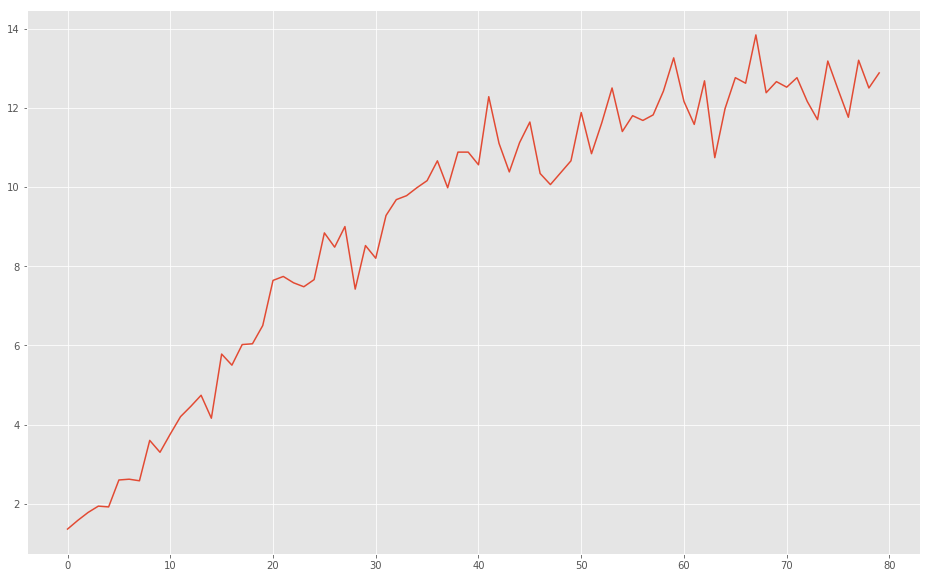

In [154]:
DTCkills = np.array(DTCkills)
avg_DTCkills = np.mean(DTCkills[:(len(DTCkills)//50)*50].reshape(-1,50), axis=1)
plt.plot(avg_DTCkills)
#plt.plot(DTCkills)

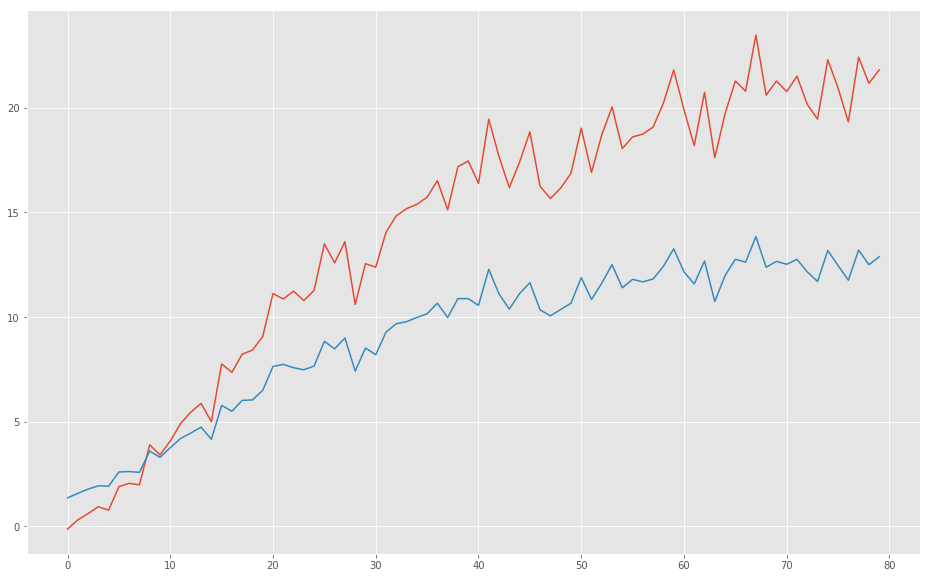

In [157]:
DTCreward = np.array(DTCreward)
avg_DTCreward = np.mean(DTCreward[:(len(DTCreward)//50)*50].reshape(-1,50), axis=1)
plt.plot(avg_DTCreward)
plt.plot(avg_DTCkills)

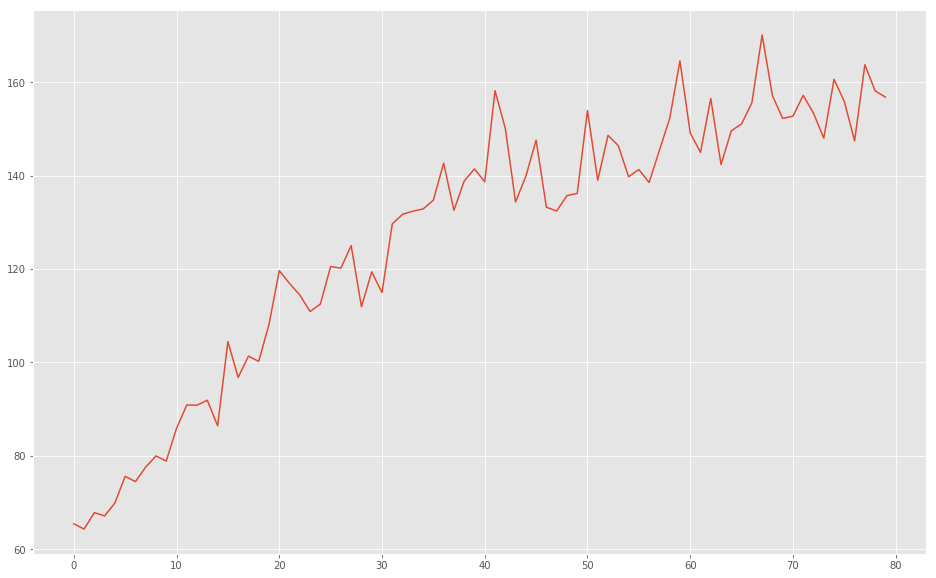

In [153]:
DTCta = np.array(DTCta)
avg_DTCreward = np.mean(DTCta[:(len(DTCta)//50)*50].reshape(-1,50), axis=1)
plt.plot(avg_DTCreward)

In [64]:
for i in range(len(allKills)):
    print(Version[i] + ": ")
    print("Mean rewards: " + str(mean(allRewards[i])))
    print("Mean loss: " + str(mean(allLoss[i])))
    print("Mean kills in: " + str(mean(allKills[i])))
    print("Mean timeAlive: " + str(mean(allTA[i])))
    print(" ")

LR_00001-Gamma_90(3k_eps60k): 
Mean rewards: 9.955664055118959
Mean loss: 0.061842404035786946
Mean kills in: 7.099333333333333
Mean timeAlive: 108
 
LR_00001-Gamma_95(3k_eps60k): 
Mean rewards: 13.381262823005518
Mean loss: 0.07754273161672014
Mean kills in: 8.920666666666667
Mean timeAlive: 125
 
LR_00001-Gamma_99(3k_eps60k): 
Mean rewards: 10.935030752676228
Mean loss: 0.29576097311345406
Mean kills in: 7.341
Mean timeAlive: 116
 
LR_0001-Gamma_90(3k_eps60k): 
Mean rewards: 10.713797021448611
Mean loss: 0.04774023010557194
Mean kills in: 7.362
Mean timeAlive: 110
 
LR_0001-Gamma_95(3k_eps60k): 
Mean rewards: 12.359762836674848
Mean loss: 0.07135900634502218
Mean kills in: 8.204
Mean timeAlive: 119
 
LR_0001-Gamma_99(3k_eps60k): 
Mean rewards: 12.936930118441582
Mean loss: 0.1221889972654963
Mean kills in: 8.390666666666666
Mean timeAlive: 121
 
LR_001-Gamma_90(3k_eps60k): 
Mean rewards: 10.440330910146237
Mean loss: 0.059648473545266006
Mean kills in: 7.1803333333333335
Mean timeAli

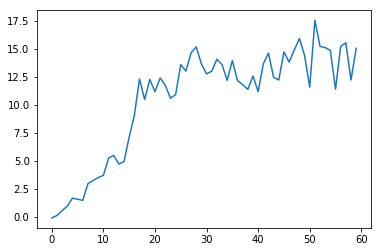

In [27]:
reward_list = np.array(reward_list)
avg_reward_list = np.mean(reward_list[:(len(reward_list)//50)*50].reshape(-1,50), axis=1)
plt.plot(avg_reward_list)

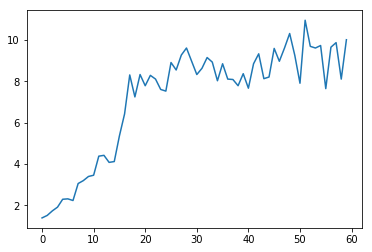

In [24]:
kills_list = np.array(kills_list)
avg_kills_list = np.mean(kills_list[:(len(kills_list)//50)*50].reshape(-1,50), axis=1)
plt.plot(avg_kills_list)

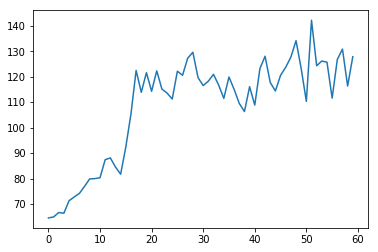

In [25]:
TA_list = np.array(TA_list)
avg_TA_list = np.mean(TA_list[:(len(TA_list)//50)*50].reshape(-1,50), axis=1)
plt.plot(avg_TA_list)

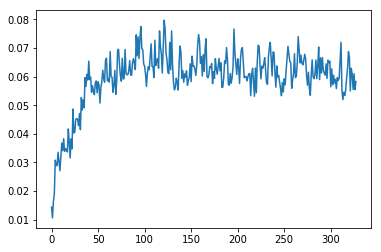

In [17]:
loss_list = np.array(loss_list)
avg_loss_list = np.mean(loss_list[:(len(loss_list)//1000)*1000].reshape(-1,1000), axis=1)
plt.plot(avg_loss_list)

In [ ]:
print(env.get_keys_to_action)